In [337]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.2 numpy==1.17.5 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.0


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.5.1 anndata==0.7.1 umap==0.4.2 numpy==1.17.5 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.0


In [7]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

# Import LUNG dataset (3Ptz)

In [4]:
path_lung="/mnt/lugli/SP028_Autoimmunity/dataset/PangenomeBlueprint/LC_counts/"
adata_lung = sc.read("".join([path_lung,"matrix.mtx"]), cache=False)
adata_lung = adata_lung.transpose()
adata_lung.X = adata_lung.X.toarray()
barcodes = pd.read_csv("".join([path_lung,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_lung,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_lung.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_lung.var = genes

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [5]:
Metadata_lung = pd.read_csv("/mnt/lugli/SP025_NaClTcell/PangenomeBlueprint/LC_metadata.csv",header=0,low_memory=False)
Metadata_lung.head()

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType
0,BT1238_AAATCAACTGCCTC,897,3227,True,1,Lung,I,Cancer
1,BT1238_AACATTGACCTAAG,509,731,True,1,Lung,I,Cancer
2,BT1238_AACCAGTGCTTAGG,642,2958,True,1,Lung,I,Myeloid
3,BT1238_AACCTACTCGCTAA,925,2781,True,1,Lung,I,T_cell
4,BT1238_AACTCTTGCTGTAG,713,3000,True,1,Lung,I,T_cell


In [6]:
adata_lung.obs['CellId'] = Metadata_lung["Cell"].to_list()
adata_lung.obs['CellFromTumor'] = Metadata_lung["CellFromTumor"].to_list()
adata_lung.obs['PatientNumber'] = Metadata_lung["PatientNumber"].to_list()
adata_lung.obs['TumorType'] = Metadata_lung["TumorType"].to_list()
adata_lung.obs['TumorSite'] = Metadata_lung["TumorSite"].to_list()
adata_lung.obs['CellType'] = Metadata_lung["CellType"].to_list()

In [7]:
print(adata_lung.obs['PatientNumber'].value_counts())

5    21167
4    17272
3    16791
7    16359
8    10765
6     6949
2     2799
1     1473
Name: PatientNumber, dtype: int64


In [8]:
adenocarcinomacell = (adata_lung.obs['PatientNumber'] == 3) | (adata_lung.obs['PatientNumber'] == 4) | (adata_lung.obs['PatientNumber'] == 6)

In [9]:
print(f'Total number of cell from Lung adenocarcinoma {sum(adenocarcinomacell)}')

Total number of cell from Lung adenocarcinoma 41012


In [10]:
adata_lung = adata_lung[adenocarcinomacell, :]

In [11]:
adata_lung.write("/mnt/lugli/SP028_Autoimmunity/h5_files/adatalung.h5ad")

/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'TumorType' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'TumorSite' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'CellType' as categorical


# Import Ovarian Cancer dataset (5Ptz)

In [94]:
path_oc="/mnt/lugli/SP028_Autoimmunity/dataset/PangenomeBlueprint/OvC_counts/"
adata_oc = sc.read("".join([path_oc,"matrix.mtx"]), cache=False)
adata_oc = adata_oc.transpose()
adata_oc.X = adata_oc.X.toarray()
barcodes = pd.read_csv("".join([path_oc,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_oc,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_oc.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_oc.var = genes

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [95]:
Metadata_oc = pd.read_csv("/mnt/lugli/SP025_NaClTcell/PangenomeBlueprint/OvC_metadata.csv",header=0,low_memory=False)
Metadata_oc.head()

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType
0,BT1303_AAACCTGAGAGCCCAA,208,951,1,11,Ovarian,Omentum,Cancer
1,BT1303_AAACCTGAGGCATGGT,249,421,1,11,Ovarian,Omentum,T_cell
2,BT1303_AAACCTGAGTATTGGA,226,407,1,11,Ovarian,Omentum,Cancer
3,BT1303_AAACCTGAGTGCAAGC,1433,2992,1,11,Ovarian,Omentum,Fibroblast
4,BT1303_AAACCTGAGTGGTAAT,259,409,1,11,Ovarian,Omentum,Cancer


In [96]:
adata_oc.obs['CellId'] = Metadata_oc["Cell"].to_list()
adata_oc.obs['CellFromTumor'] = Metadata_oc["CellFromTumor"].to_list()
adata_oc.obs['PatientNumber'] = Metadata_oc["PatientNumber"].to_list()
adata_oc.obs['TumorType'] = Metadata_oc["TumorType"].to_list()
adata_oc.obs['TumorSite'] = Metadata_oc["TumorSite"].to_list()
adata_oc.obs['CellType'] = Metadata_oc["CellType"].to_list()

In [97]:
print(adata_oc.obs['PatientNumber'].value_counts())

11    22255
14     6257
15     6001
13     5450
12     5151
Name: PatientNumber, dtype: int64


In [98]:
print('Total number of cells from Ovarian cancer is ',sum(adata_oc.obs['PatientNumber']))

Total number of cells from Ovarian cancer is  555080


# Import Colorectal Cancer dataset (7Ptz)

In [64]:
path_crc="/mnt/lugli/SP028_Autoimmunity/dataset/PangenomeBlueprint/CRC_counts/"
adata_crc = sc.read("".join([path_crc,"matrix.mtx"]), cache=False)
adata_crc = adata_crc.transpose()
adata_crc.X = adata_crc.X.toarray()
barcodes = pd.read_csv("".join([path_crc,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_crc,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_crc.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_crc.var = genes

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [65]:
adata_crc

AnnData object with n_obs × n_vars = 44684 × 33694 
    var: 'gene_id'

In [66]:
Metadata_crc = pd.read_csv("/mnt/lugli/SP025_NaClTcell/PangenomeBlueprint/CRC_metadata.csv",header=0,low_memory=False)
Metadata_crc.head()

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType
0,scrEXT001_AAACCTGGTCGGCTCA,345,633,True,31,CRC,C,Cancer
1,scrEXT001_AAACCTGGTCTTTCAT,2640,8119,True,31,CRC,C,Cancer
2,scrEXT001_AAACCTGTCACCACCT,2129,6999,True,31,CRC,C,Myeloid
3,scrEXT001_AAACCTGTCGTCCAGG,1297,3351,True,31,CRC,C,T_cell
4,scrEXT001_AAACCTGTCTGGGCCA,4912,23972,True,31,CRC,C,Fibroblast


In [67]:
adata_crc.obs['CellId'] = Metadata_crc["Cell"].to_list()
adata_crc.obs['CellFromTumor'] = Metadata_crc["CellFromTumor"].to_list()
adata_crc.obs['PatientNumber'] = Metadata_crc["PatientNumber"].to_list()
adata_crc.obs['TumorType'] = Metadata_crc["TumorType"].to_list()
adata_crc.obs['TumorSite'] = Metadata_crc["TumorSite"].to_list()
adata_crc.obs['CellType'] = Metadata_crc["CellType"].to_list()

In [80]:
print('Total number of cells from colorectal cancer is ',sum(adata_crc.obs['PatientNumber']))

Total number of cells from colorectal cancer is  1501634


# Import Breast Cancer dataset (14Ptz)

In [84]:
path_bc="/mnt/lugli/SP028_Autoimmunity/dataset/PangenomeBlueprint/BC_counts/"
adata_bc = sc.read("".join([path_bc,"matrix.mtx"]), cache=False)
adata_bc = adata_bc.transpose()
adata_bc.X = adata_bc.X.toarray()
barcodes = pd.read_csv("".join([path_bc,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_bc,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_bc.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_bc.var = genes

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [85]:
adata_bc

AnnData object with n_obs × n_vars = 44024 × 33694 
    var: 'gene_id'

In [86]:
Metadata_bc = pd.read_csv("/mnt/lugli/SP025_NaClTcell/PangenomeBlueprint/BC_metadata.csv",header=0,low_memory=False)
Metadata_bc.head()

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType
0,sc5rJUQ024_AAACCTGCAACAACCT,894,1624,True,41,BC,Biopsy,DC
1,sc5rJUQ024_AAACCTGCAAGAAGAG,1401,2983,True,41,BC,Biopsy,T_cell
2,sc5rJUQ024_AAACCTGGTCTCCACT,585,1141,True,41,BC,Biopsy,Cancer
3,sc5rJUQ024_AAACCTGTCAACGAAA,4233,18953,True,41,BC,Biopsy,Myeloid
4,sc5rJUQ024_AAACGGGAGAGTAAGG,1669,3794,True,41,BC,Biopsy,Fibroblast


In [87]:
adata_bc.obs['CellId'] = Metadata_bc["Cell"].to_list()
adata_bc.obs['CellFromTumor'] = Metadata_bc["CellFromTumor"].to_list()
adata_bc.obs['PatientNumber'] = Metadata_bc["PatientNumber"].to_list()
adata_bc.obs['TumorType'] = Metadata_bc["TumorType"].to_list()
adata_bc.obs['TumorSite'] = Metadata_bc["TumorSite"].to_list()
adata_bc.obs['CellType'] = Metadata_bc["CellType"].to_list()

In [88]:
print(adata_bc.obs['PatientNumber'].value_counts())

42    4876
51    4862
49    4616
45    4472
43    4251
54    4216
41    3921
53    3641
44    3558
48    2427
47    1719
50     902
52     362
46     201
Name: PatientNumber, dtype: int64


In [89]:
print('Total number of cells from Breast cancer is ',sum(adata_bc.obs['PatientNumber']))

Total number of cells from Breast cancer is  2071380


# Extract T_cells from Cancer Samples

In [99]:
adata_lung = adata_lung[adata_lung.obs['CellType']  == "T_cell",:]
adata_crc = adata_crc[adata_crc.obs['CellType']  == "T_cell",:]
adata_oc = adata_oc[adata_oc.obs['CellType']  == "T_cell",:]
adata_bc = adata_bc[adata_bc.obs['CellType']  == "T_cell",:]

In [105]:
print('Total number of T cells from Lung cancer is ',sum(adata_lung.obs['PatientNumber']))

Total number of T cells from Lung cancer is  73771


In [106]:
print('Total number of T cells from Ovarian cancer is ',sum(adata_oc.obs['PatientNumber']))

Total number of T cells from Ovarian cancer is  73534


In [107]:
print('Total number of T cells from Colorectal cancer is ',sum(adata_crc.obs['PatientNumber']))

Total number of T cells from Colorectal cancer is  291953


In [108]:
print('Total number of T cells from breast cancer is ',sum(adata_bc.obs['PatientNumber']))

Total number of T cells from breast cancer is  662836


# Import SLE dataset

In [187]:
SLE = sc.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/SLE_RNA_sequencing_result/SDY997_EXP15176_celseq_matrix_ru10_molecules.tsv",delimiter='\t', first_column_names=True)

In [188]:
SLE = SLE.T

In [189]:
SLE

AnnData object with n_obs × n_vars = 8296 × 30155 

In [190]:
Meta_sle = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/SLE_RNA_sequencing_result/SDY997_EXP15176_celseq_meta.tsv",sep="\t",header=0)

In [198]:
Meta_sle.head()

,cell_name,barcode,sample,type,disease,plate,lane,quadrant,well384,picard_pf_bases,...,genes_detected_ru1,genes_detected_reads_ru1,percent_mt_molecules_ru1,percent_mt_reads_ru1,reads,molecules,genes_detected,percent_mt_molecules,percent_top10,quadName
777,K005_L1Q1_C13,GACATG,200-0109,Leukocyte,SLE,K005,1,1,C13,36839907,...,3173,3173,0.122160,0.149792,444024,4922,2377,0.082080,0.112556,K005_L1Q1
778,K005_L1Q1_C15,AGGAAG,200-0109,Leukocyte,SLE,K005,1,1,C15,19956321,...,2441,2441,0.152190,0.127877,237225,3142,1663,0.090707,0.127307,K005_L1Q1
779,K005_L1Q1_C17,CAGACA,200-0109,Leukocyte,SLE,K005,1,1,C17,12480885,...,1387,1387,0.317718,0.423460,92358,1173,621,0.304348,0.340153,K005_L1Q1
780,K005_L1Q1_C19,GTTGTC,200-0109,Leukocyte,SLE,K005,1,1,C19,31044345,...,2788,2788,0.164030,0.235383,341872,3989,1950,0.134119,0.157433,K005_L1Q1
781,K005_L1Q1_C21,CTTCAC,200-0109,Leukocyte,SLE,K005,1,1,C21,33110296,...,2964,2964,0.120410,0.143726,471365,5093,2164,0.084430,0.111722,K005_L1Q1


In [194]:
Meta_sle = Meta_sle.loc[(Meta_sle['sample']!= "none") & (Meta_sle['disease']== "SLE")]

In [195]:
SLE = SLE[SLE.obs_names.isin(Meta_sle['cell_name'].to_list()),:]

In [196]:
# Subset Leukocytes
Meta_sle = Meta_sle.loc[Meta_sle['type'] == "Leukocyte"]
SLE = SLE[SLE.obs_names.isin(Meta_sle['cell_name'].to_list()),:]

In [197]:
SLE.obs['CellId'] = Meta_sle["cell_name"].to_list()
SLE.obs['CellFromTumor'] = False
SLE.obs['PatientNumber'] = Meta_sle["sample"].to_list()
SLE.obs['TumorType'] = Meta_sle["disease"].to_list()
SLE.obs['TumorSite'] = "Kidneys"
SLE.obs['CellType'] = Meta_sle["type"].to_list()

View of AnnData object with n_obs × n_vars = 5427 × 30155 

# Import RA

In [283]:
df = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/RA_RNA_sequencing_result/celseq_matrix_ru10_molecules.tsv.725585.gz",sep="\t",header=0)

In [284]:
df = df.fillna(0)

In [285]:
df = df.T

In [286]:
df.to_csv("/mnt/lugli/SP028_Autoimmunity/dataset/RA_RNA_sequencing_result/celseq_matrix_ru10_molecules.tsv",sep="\t",header=False,index=True)

In [287]:
RA = sc.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/RA_RNA_sequencing_result/celseq_matrix_ru10_molecules.tsv",delimiter='\t', first_column_names=True)

In [288]:
RA

AnnData object with n_obs × n_vars = 10099 × 29420 

In [289]:
Metadata_ra = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/RA_RNA_sequencing_result/celseq_meta_unfiltered.tsv",sep="\t",header=0)

In [290]:
Metadata_ra = Metadata_ra.loc[(Metadata_ra['sample']!= "none") & (Metadata_ra['disease'] == "RA")]

In [291]:
Metadata_ra = Metadata_ra.loc[Metadata_ra['type'] == "T cell"]

In [292]:
RA = RA[RA.obs_names.isin(Metadata_ra['cell_name'].to_list()),:]

In [293]:
RA

View of AnnData object with n_obs × n_vars = 2707 × 29420 

In [303]:
Metadata_ra = pd.merge(pd.DataFrame(RA.obs_names.to_series()),Metadata_ra,left_on=0,right_on="cell_name")

In [304]:
RA.obs['CellId'] = Metadata_ra["cell_name"].to_list()
RA.obs['CellFromTumor'] = False
RA.obs['PatientNumber'] = Metadata_ra["sample"].to_list()
RA.obs['TumorType'] = Metadata_ra["disease"].to_list()
RA.obs['TumorSite'] = "SynovialFluid"
RA.obs['CellType'] = Metadata_ra["type"].to_list()

Trying to set attribute `.obs` of view, copying.


# Data Integration

In [311]:
adata = RA.concatenate(SLE,adata_bc,adata_crc,adata_lung,adata_oc,index_unique=None)

In [309]:
adata

AnnData object with n_obs × n_vars = 8134 × 26884 
    obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts'

In [312]:
adata.write("/mnt/lugli/SP028_Autoimmunity/h5_files/Concatenate_T_cell.h5ad")

... storing 'CellType' as categorical
... storing 'PatientNumber' as categorical
... storing 'TumorSite' as categorical
... storing 'TumorType' as categorical
... storing 'zero_counts' as categorical


In [315]:
adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Concatenate_T_cell.h5ad")

In [316]:
print(adata.X.shape)

(56365, 23062)


In [318]:
adata2 = adata.copy()

sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)

normalizing by total count per cell
    finished (0:01:42): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:25)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


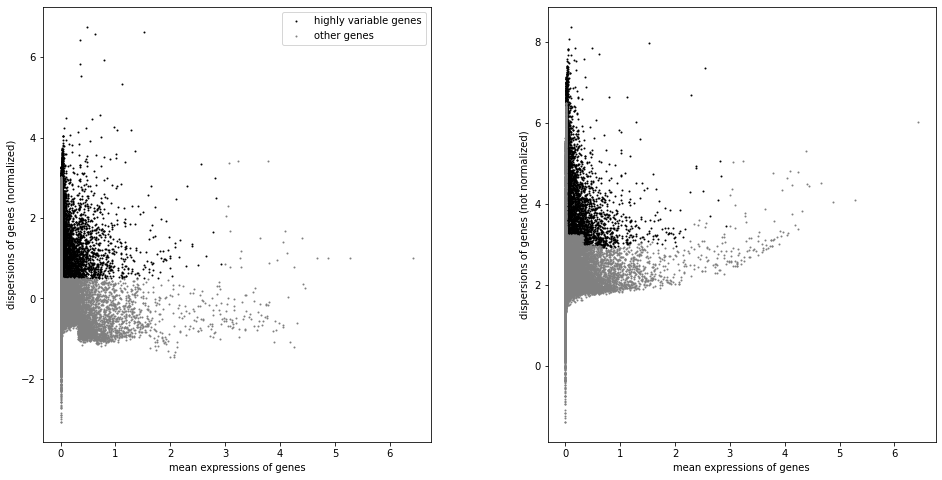

Highly variable genes: 3542


In [319]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata2)

print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

In [323]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'batch')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:24)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 55
Number of batches where gene is variable:
0    11976
1     6559
2     2639
3     1109
4      506
5      218
6       55
Name: highly_variable_nbatches, dtype: int64


In [324]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches ==3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 11086
All data var genes: 2177
Overlap: 2175
Variable genes in all batches: 1109
Overlap batch instersection and all: 55


In [325]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)


4527

In [329]:
# split per batch into new objects.
batches = ['RA','SLE','BC','CRC','Lung','Ovarian']
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['TumorType'] == batch,]

alldata 

{'RA': View of AnnData object with n_obs × n_vars = 2707 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p',
 'SLE': View of AnnData object with n_obs × n_vars = 5427 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p',
 'BC': View of AnnData object with n_obs × n_vars = 14395 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'ge

In [344]:
cdata = sc.external.pp.mnn_correct(alldata['RA'],alldata['SLE'],alldata['BC'],alldata['CRC'],alldata['Lung'],alldata['Ovarian'],
                                   svd_dim = 50, batch_key = 'TumorType', batch_categories = ['RA','SLE','BC','CRC','Lung','Ovarian'],save_raw = True,
                                   var_subset = var_genes)

/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, A))
  dist[i, j] = np.dot(m[i], n[j])
/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  scale = np.dot(working, grad)
/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/mnnpy/utils.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  curproj = np.dot(grad, curcell)
/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/mnnpy/utils.py:219: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  sameproj = np.dot(grad, samecell)
/home/spuccio/miniconda3/envs

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...


IndexError: index 2707 is out of bounds for axis 0 with size 2707

In [345]:
alldata

{'RA': View of AnnData object with n_obs × n_vars = 2707 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p',
 'SLE': View of AnnData object with n_obs × n_vars = 5427 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'gene_id-2', 'gene_id-3', 'gene_id-4', 'gene_id-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p',
 'BC': View of AnnData object with n_obs × n_vars = 14395 × 23062 
     obs: 'CellFromTumor', 'CellId', 'CellType', 'PatientNumber', 'TumorSite', 'TumorType', 'batch', 'zero_counts', 'n_counts'
     var: 'ge

In [347]:
alldata['RA'].var

,gene_id-2,gene_id-3,gene_id-4,gene_id-5,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
A1BG,A1BG,A1BG,A1BG,A1BG,False,0.239584,1.695040,-0.385515,0,False
A1BG-AS1,A1BG-AS1,A1BG-AS1,A1BG-AS1,A1BG-AS1,False,0.069760,1.768090,-0.116103,0,False
A1CF,A1CF,A1CF,A1CF,A1CF,False,0.010191,1.374626,-0.010254,3,False
A2M,A2M,A2M,A2M,A2M,False,0.147814,2.194941,0.434727,4,False
A2M-AS1,A2M-AS1,A2M-AS1,A2M-AS1,A2M-AS1,True,0.205136,2.184089,0.575672,3,False
...,...,...,...,...,...,...,...,...,...,...
ZYG11A,ZYG11A,ZYG11A,ZYG11A,ZYG11A,False,0.002781,1.212010,-0.068325,1,False
ZYG11B,ZYG11B,ZYG11B,ZYG11B,ZYG11B,False,0.159807,1.918454,0.084336,1,False
ZYX,ZYX,ZYX,ZYX,ZYX,False,0.880038,2.024590,-0.663173,0,False
ZZEF1,ZZEF1,ZZEF1,ZZEF1,ZZEF1,False,0.352405,2.402992,0.313773,1,False
